## Interpretação do efeito da decomposição STL sobre o processo de treinamento da SVM Linear

Vou usar 2 das 30 séries temporais que consideramos para tentar interpretar o que está acontecendo, a primeira é Wine: Sparkling que foi uma das séries temporais em que o nosso framework superou a técnica clássica. 

O primeiro é só um time plot para termos uma noção do que estamos trabalhando, mas o que realmente chamou minha atenção foram os lag plots. No primeiro lag plot é a série temporal crua (só com transformação log), vejam que entre os lags 1 e 11 temos algo que lembra uma parábola rotacionada, sem fazer uma mudança de coordenadas não existe função que modela isso. Agora no segundo lag plot que é a série com sazonalidade ajustada (trend + residual) vejam que temos algo que pode ser aproximado por uma reta (por isso acho que os modelos lineares são mais beneficiados). O último lag plot é o do trend, que aparece uns padrões bem esquisitos quando chegamos perto do 12º lag, que também não são funções, creio que isso justifica a necessidade de modelar os residuos junto com o trend, deixa a solução final mais robusta e a regularização força o modelo à aprender essa versão mais amigável do trend (média sobre todos os resíduos possíveis), por isso a abordagem bayesiana foi tão bem. 

Em seguida comparei a solução dada pela SVM Linear clássica e pela Híbrida, o barplot mostra os parâmetros aprendidos por cada modelo, me parece que a STL funciona como uma operação que balanceia a importância das features, ou seja, ela "adiciona" features importantes para a modelagem, por isso os resultados são melhores nos casos em que pontuamos.

A segunda é Reservoir, que foi um dos casos em que nosso framework foi mal em razão de suposições não estarem satisfeitas, dá pra ver que não existe diferença visual entre os lags plots da série crua e da adjustada, mas a solução final do modelo muda bastante como pode ser visto no último gráfico desse notebook. A STL fez o que deveria: redistribuiu a importância das features, mas como os dois conjuntos de dados são praticamente os mesmos, então porque as duas soluções não foram proporcionais? Essa deve ser a razão de nesses casos o erro ser maior do que a estratégia clássica.

Acho que é porque a STL distribui a "força" do lag 12 entre os demais, se o lag 12 não é forte o suficiente, pelo fato da série não ter um padrão sazonal grande ou por ter ficado nos resíduos, então ela divide informação faltante entre os demais lags, por isso a previsão não é boa.

In [1]:
library(forecast)
library(tibble)
library(dplyr)
library(tidyr)
library(ggplot2)
library(e1071)
library(ggdark)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
options(repr.plot.width = 15, repr.plot.height = 10)

In [3]:
read_data <- function(path, start, end, log) {
    data <- path %>% scan() %>% ts(start = start, end = end, frequency = 12)
    N <- length(data)
    testsize <- 0.05*N %>% as.integer()
    
    if(log) {
        data <- log(data)
    }
    train <- data %>% subset(end = N-testsize)
    return(train)
}

train_svm <- function(data) {
    dtrain <- tibble(lag12 = data %>% c() %>% lag(n = 12))
    for(i in 11:1) {
        dtrain[paste("lag", i, sep="")] <- data %>% c() %>% lag(n=i)
    }
    dtrain["Y"] <- data
    dtrain <- dtrain %>% drop_na()
    return(svm(Y ~ ., data = dtrain, kernel = "linear"))
}

plot_coeffs <- function(fit, fit_seasadj) {
    coefs <- data.frame(
        Model = c(rep("Linear SVR", 13), rep("Hybrid Linear SVR", 13)),
        Lags = rep(attributes(coef(fit))$names, 2),
        Coefficients = abs(c(as.numeric(coef(fit)), as.numeric(coef(fit_seasadj))))
    )
    ggplot(data=coefs, aes(x=Lags, y=Coefficients, fill=Model)) +
        geom_bar(stat="identity") +
        theme(text = element_text(size=20))
}

## Wine: Sparkling

In [4]:
train <- read_data("./datasets/wine_sparkling.data", start = c("1980", "01"), end = c("1995", "07"), T)

Inverted geom defaults of fill and color/colour.
To change them back, use invert_geom_defaults().



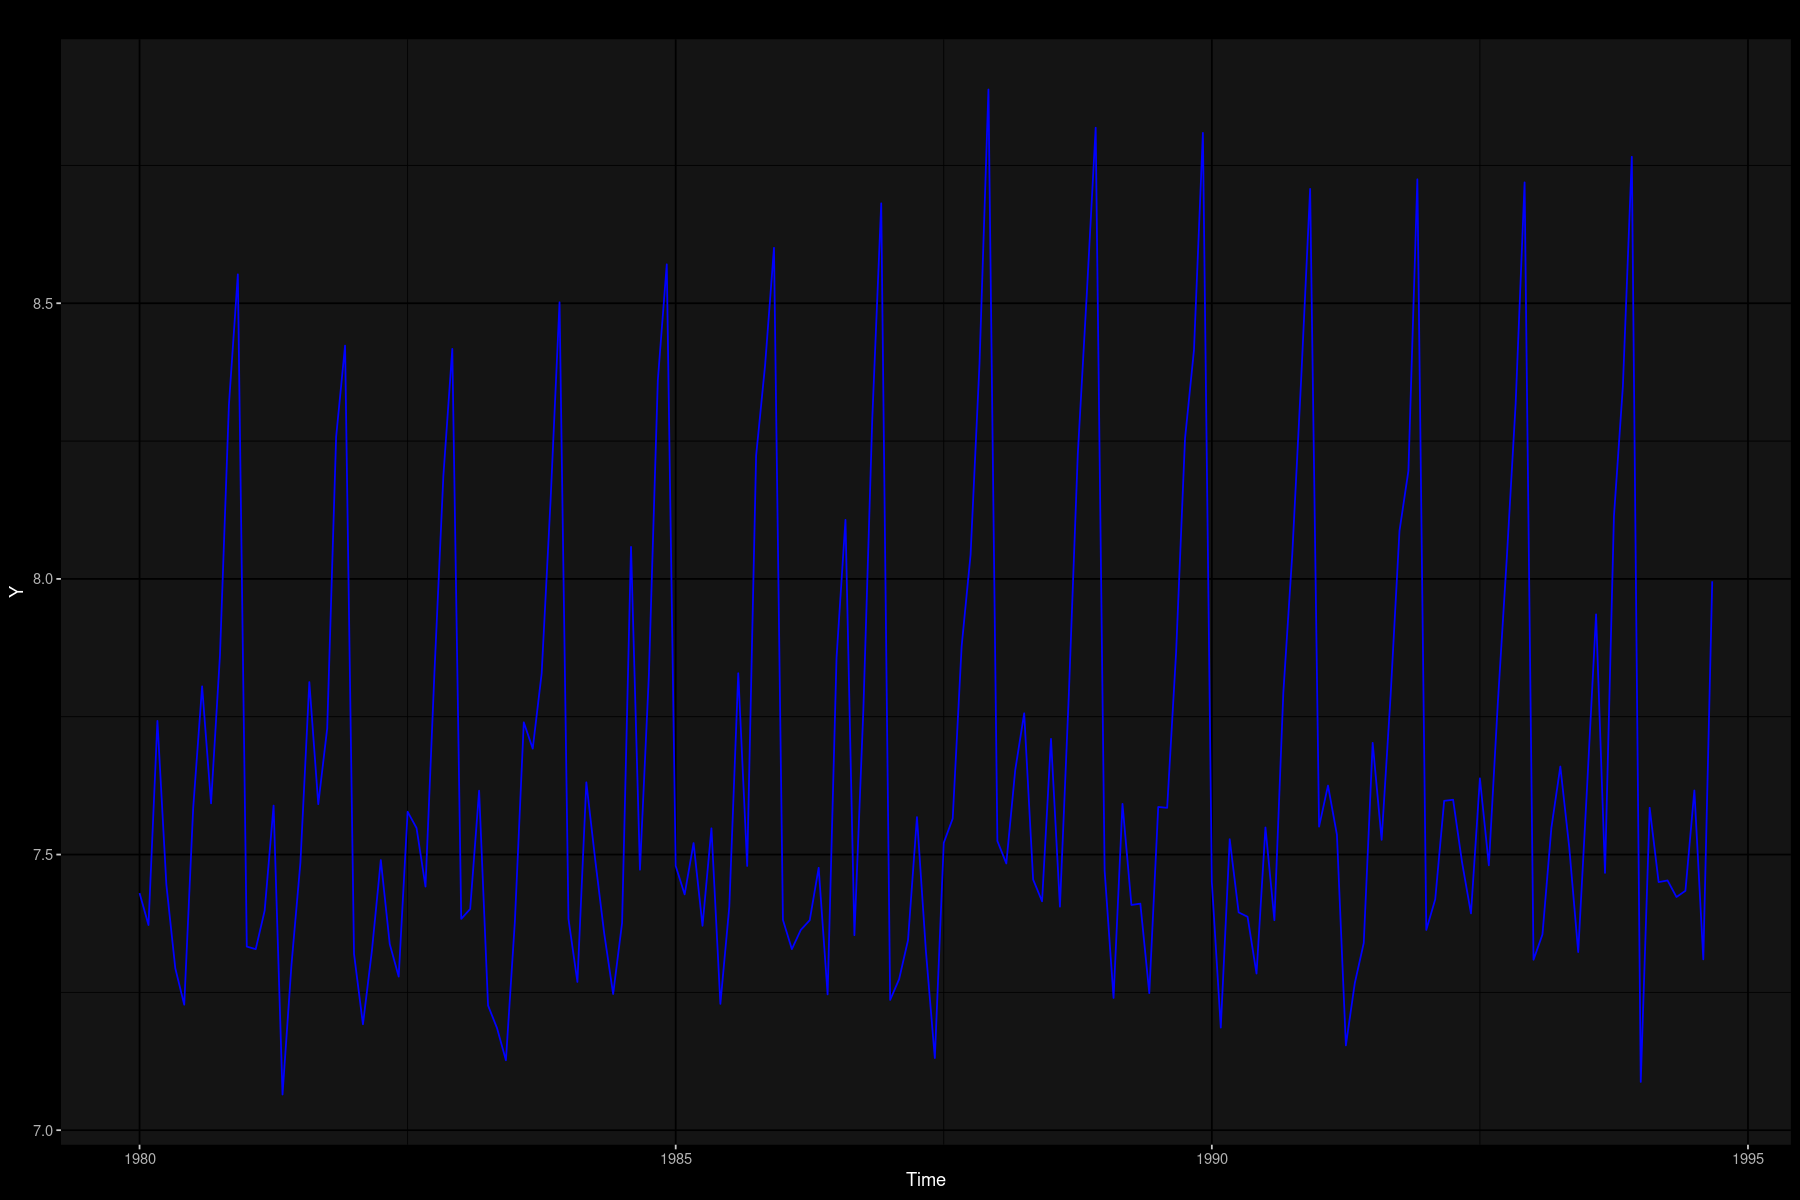

In [5]:
train %>% autoplot(color = "blue") + ylab("Y") + theme(text = element_text(size=20)) + dark_theme_gray()

## Lag Plot da série crua

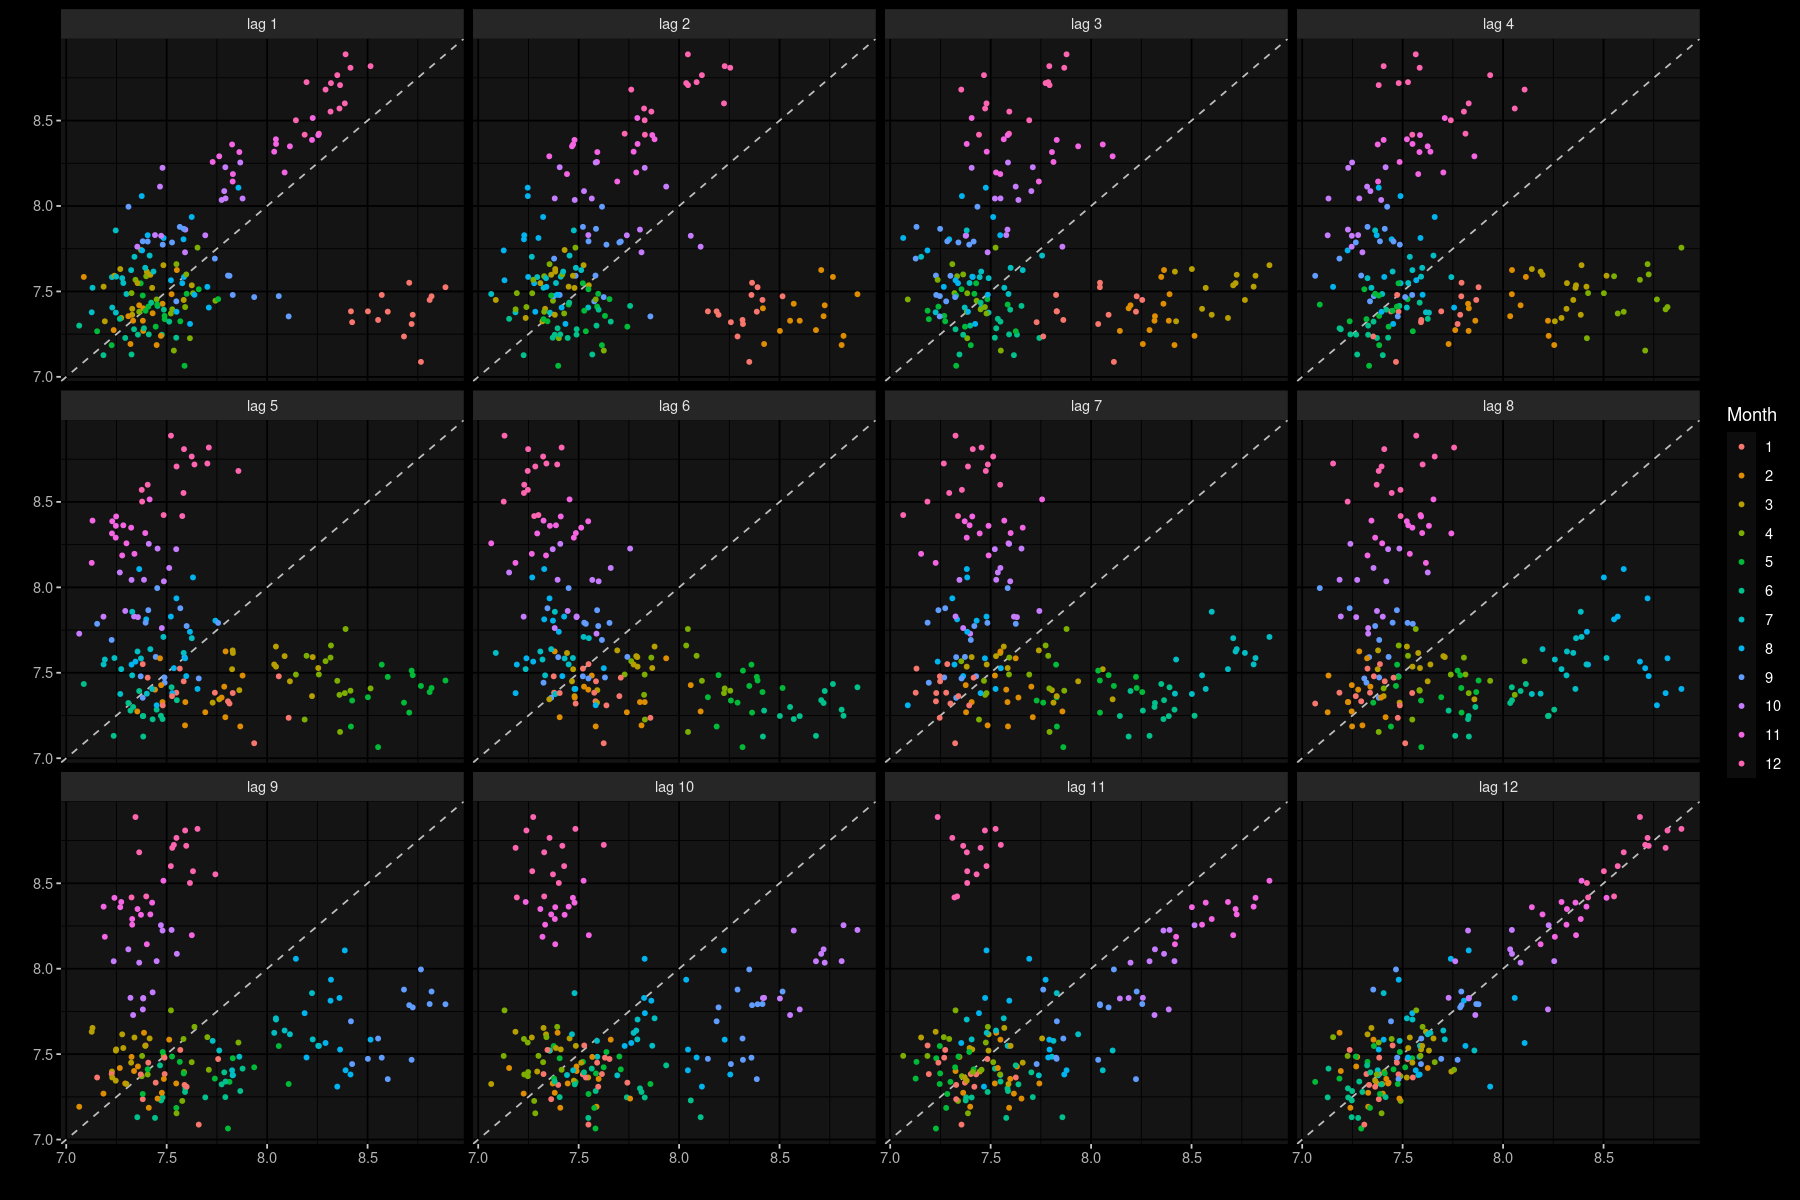

In [6]:
train %>% gglagplot(lag=12, do.lines = F) + theme(text = element_text(size=20)) + dark_theme_gray()

In [7]:
dcmp <- train %>% mstl()
train_seasadj <- dcmp %>% seasadj()

## Lag Plot da série ajustada sazonalmente

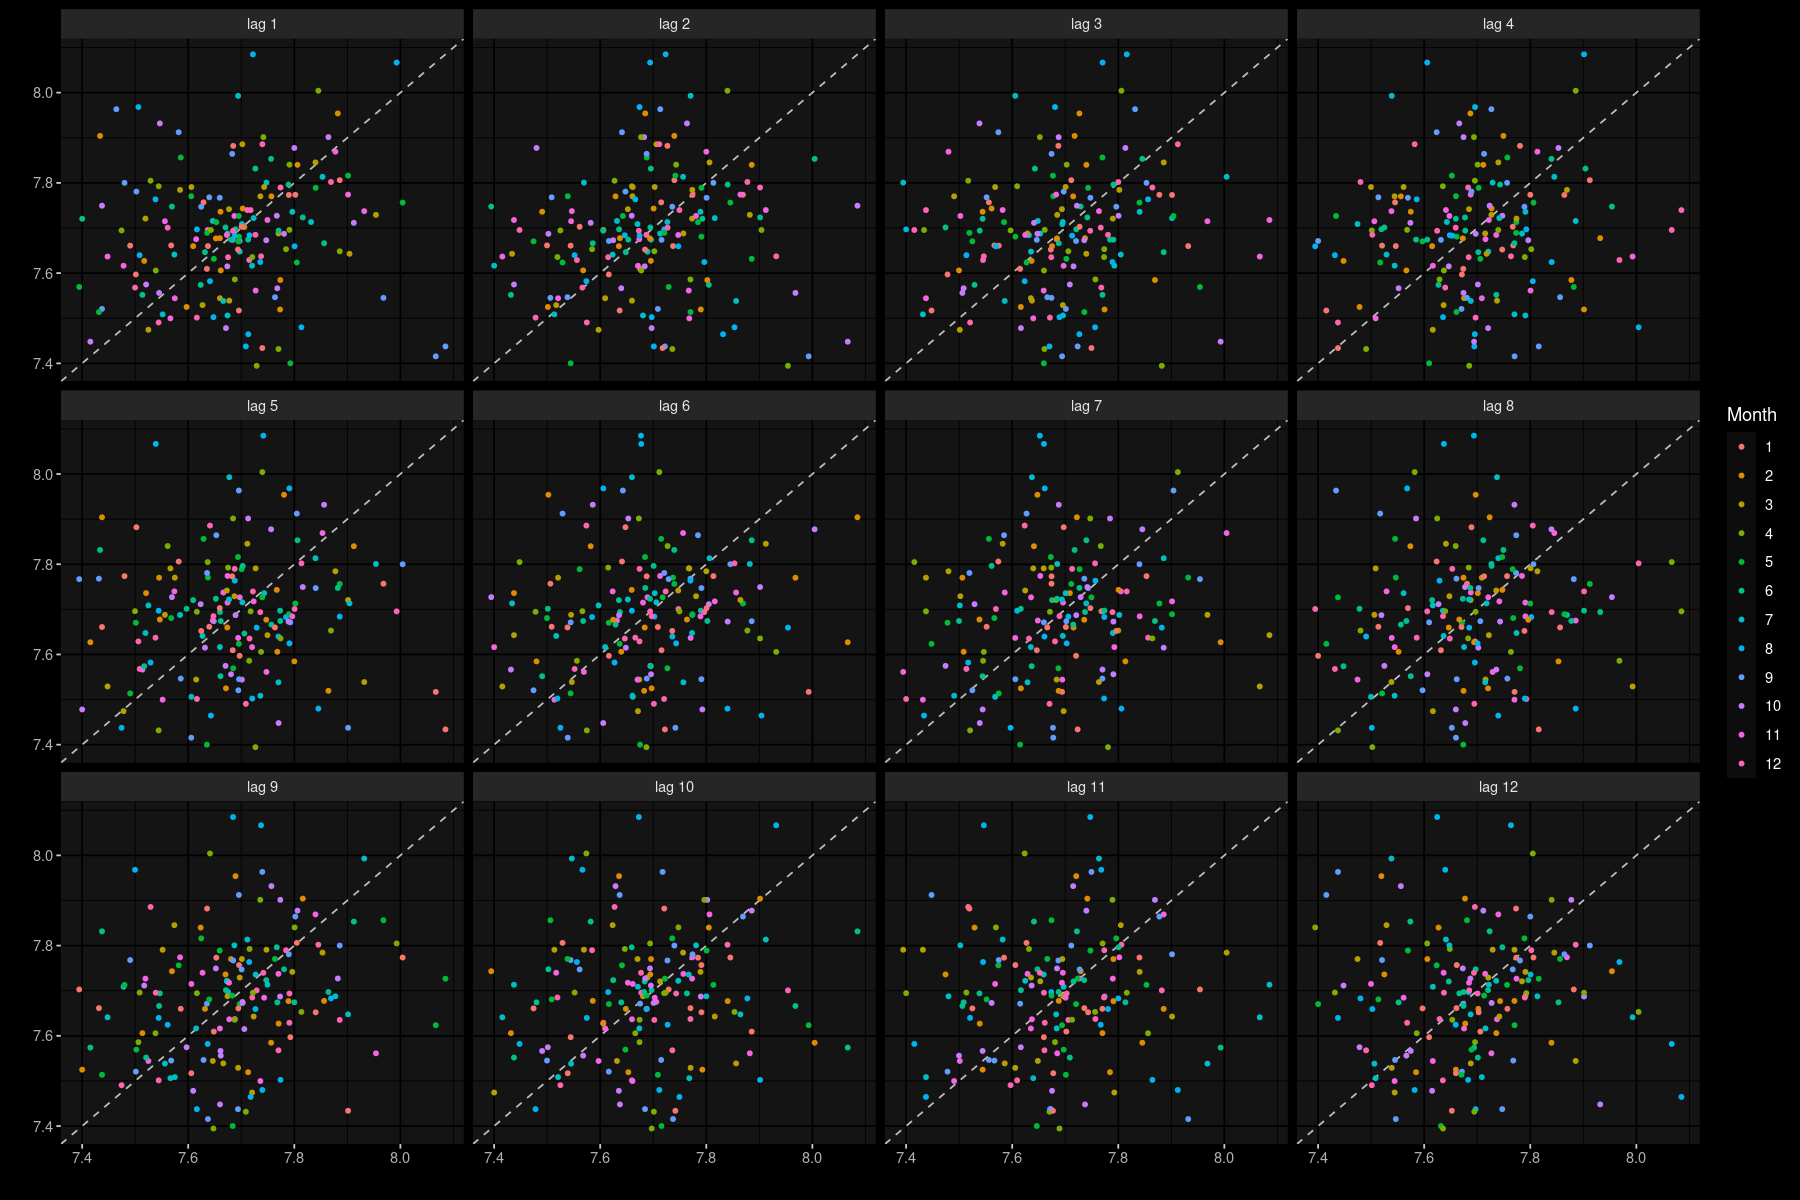

In [8]:
train_seasadj %>% gglagplot(lag=12, do.lines = F) + theme(text = element_text(size=20)) + dark_theme_gray()

## Lag Plot do Trend

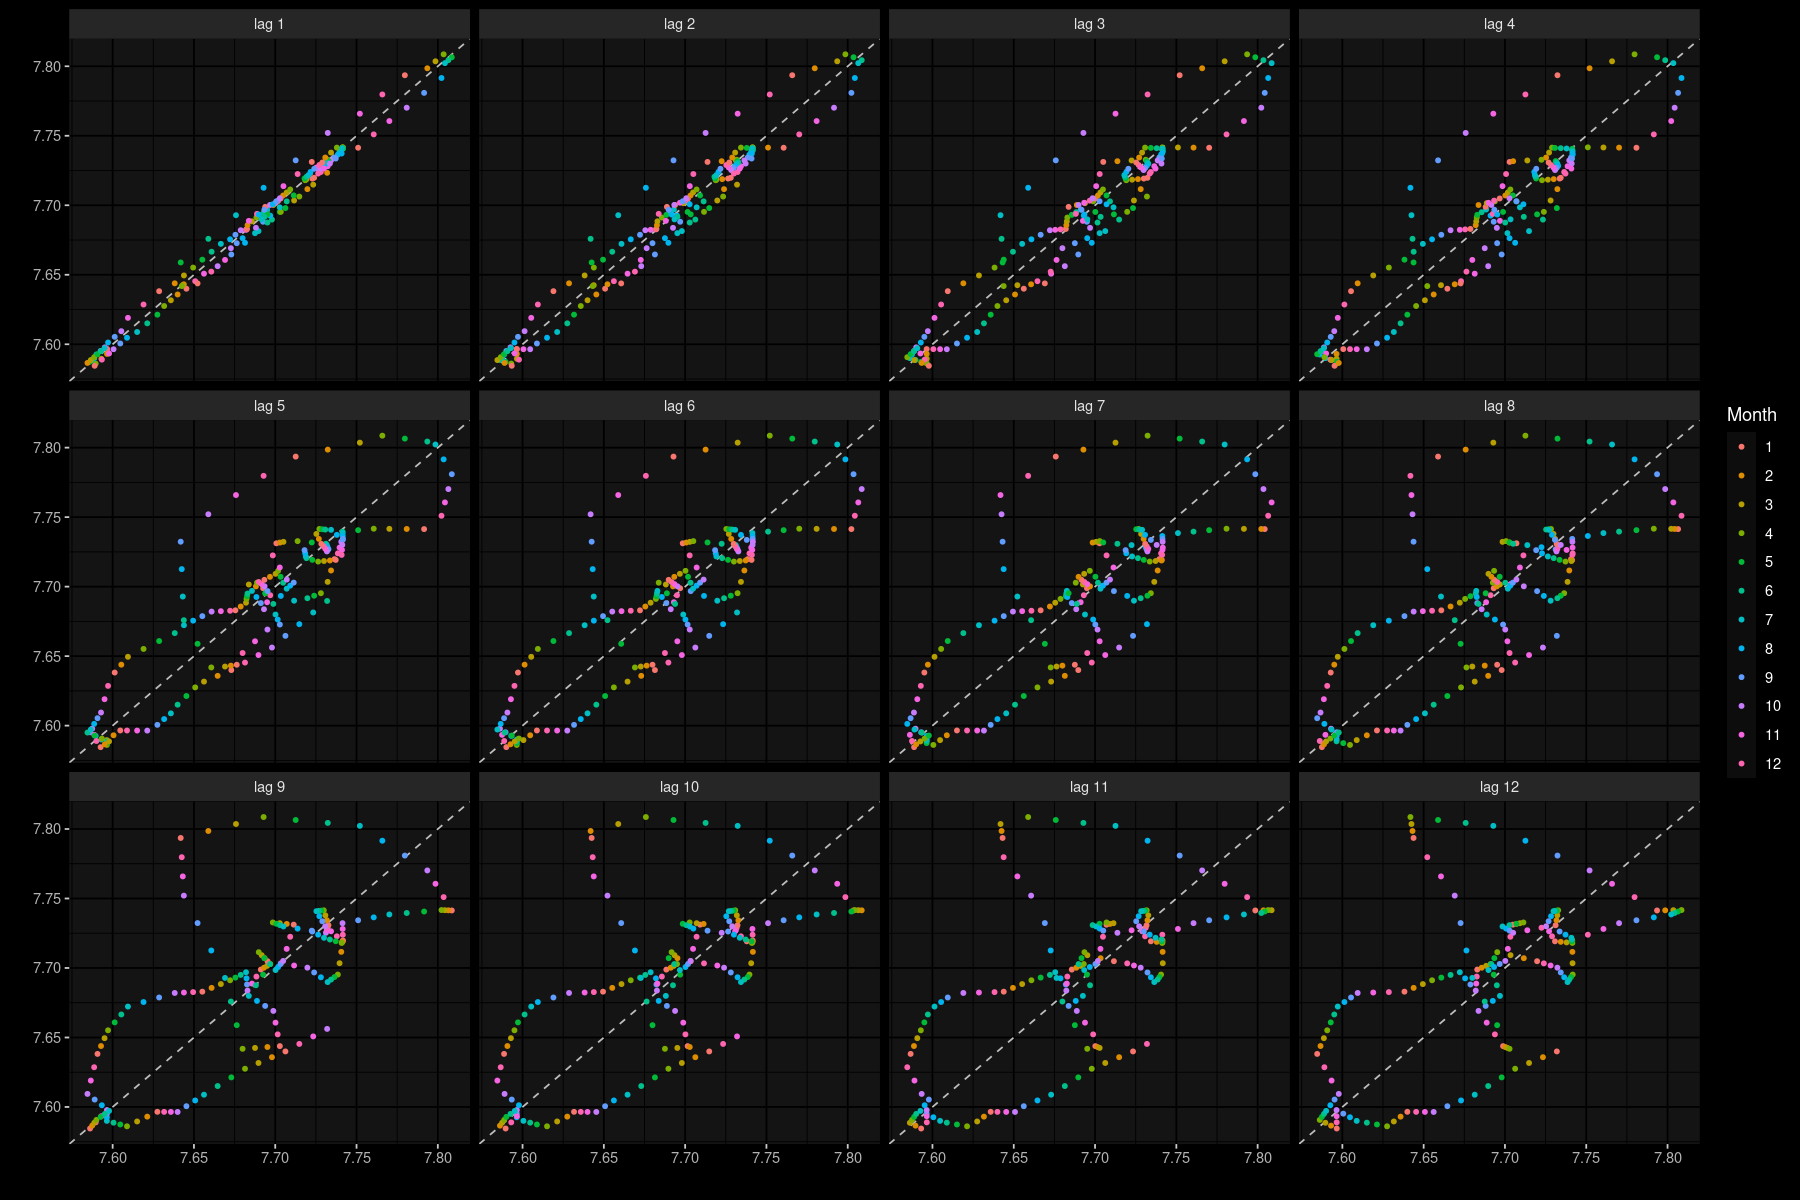

In [9]:
dcmp %>% trendcycle() %>% gglagplot(lag=12, do.lines = F) + theme(text = element_text(size=20)) + dark_theme_gray()

## Coeficientes da SVR clássica em azul e da Híbrida em rosa

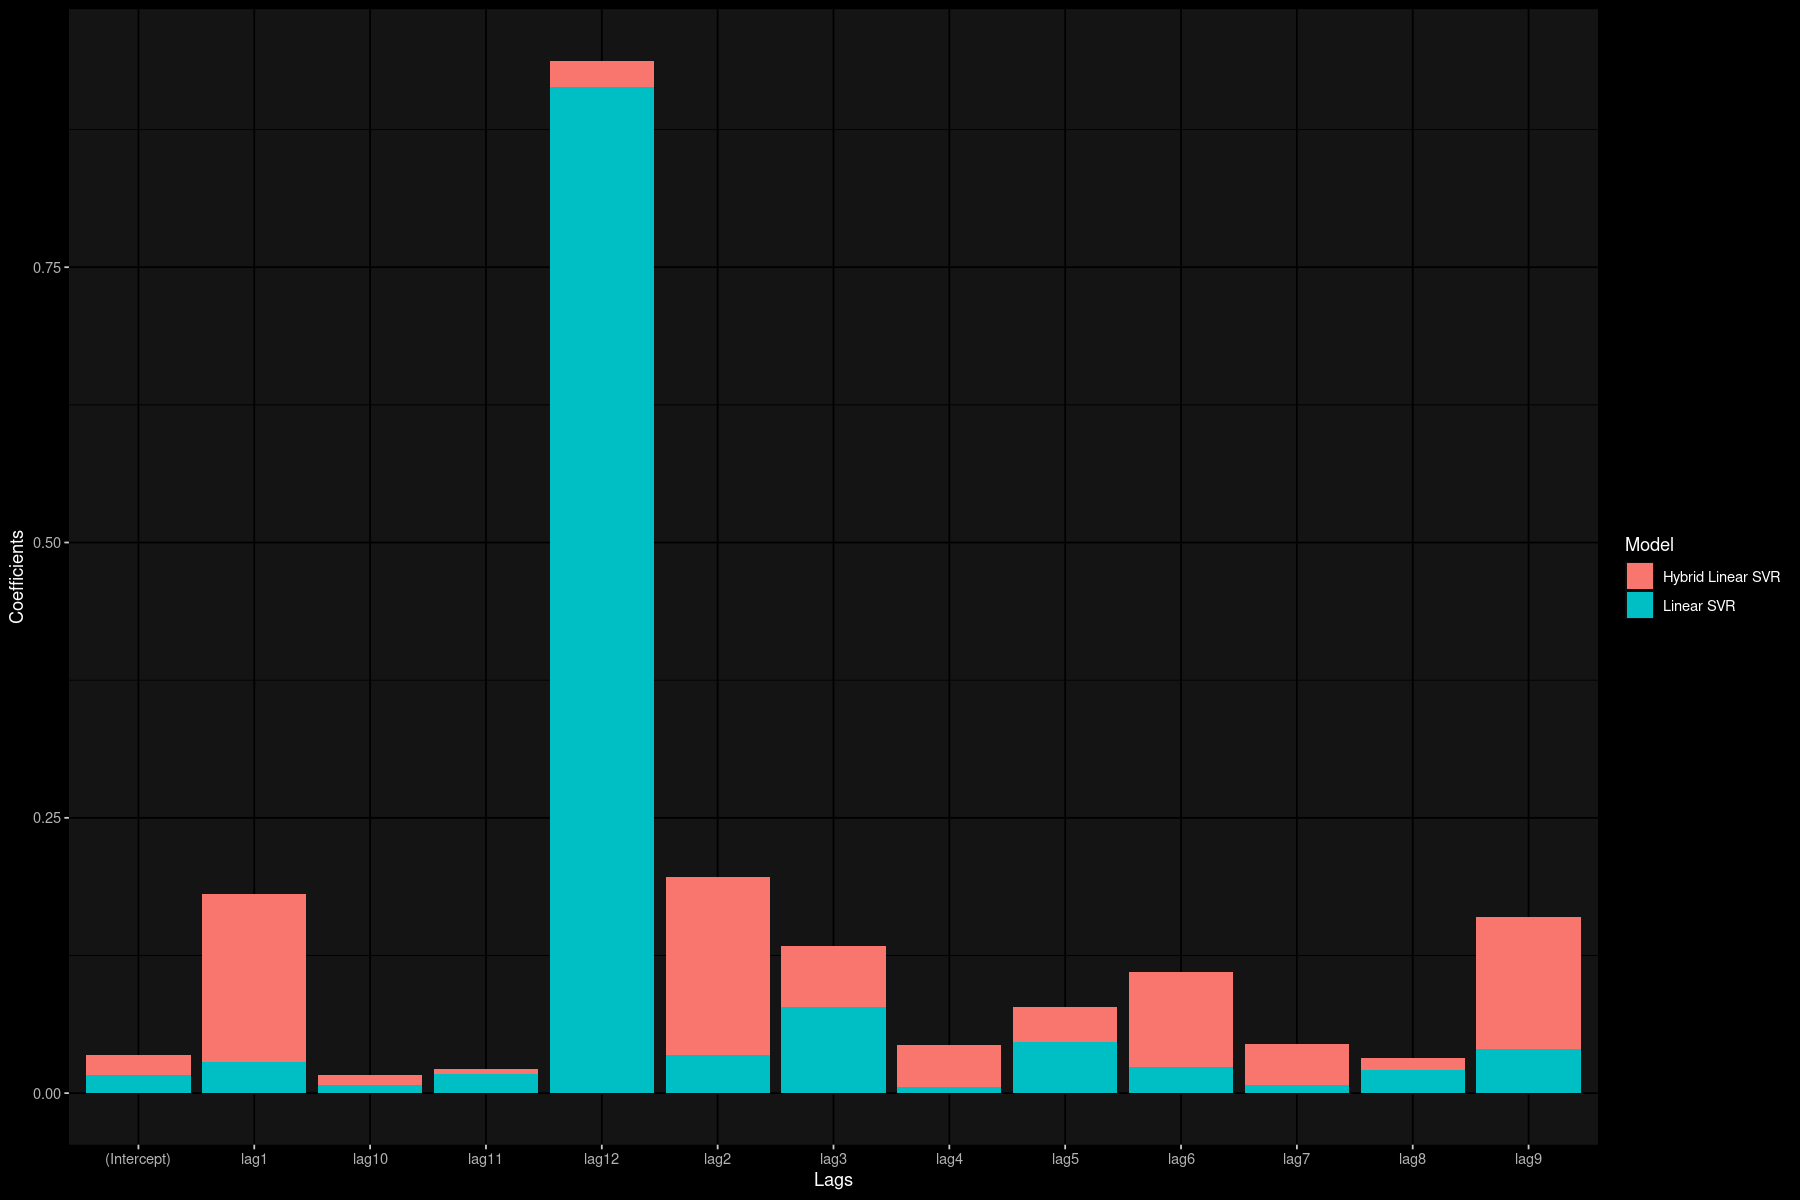

In [10]:
plot_coeffs(train_svm(train), train_svm(train_seasadj)) + dark_theme_gray()

## Reservoir

In [11]:
train <- read_data("./datasets/reservoir.data", start = c("1909", "01"), end = c("1980", "12"), F)

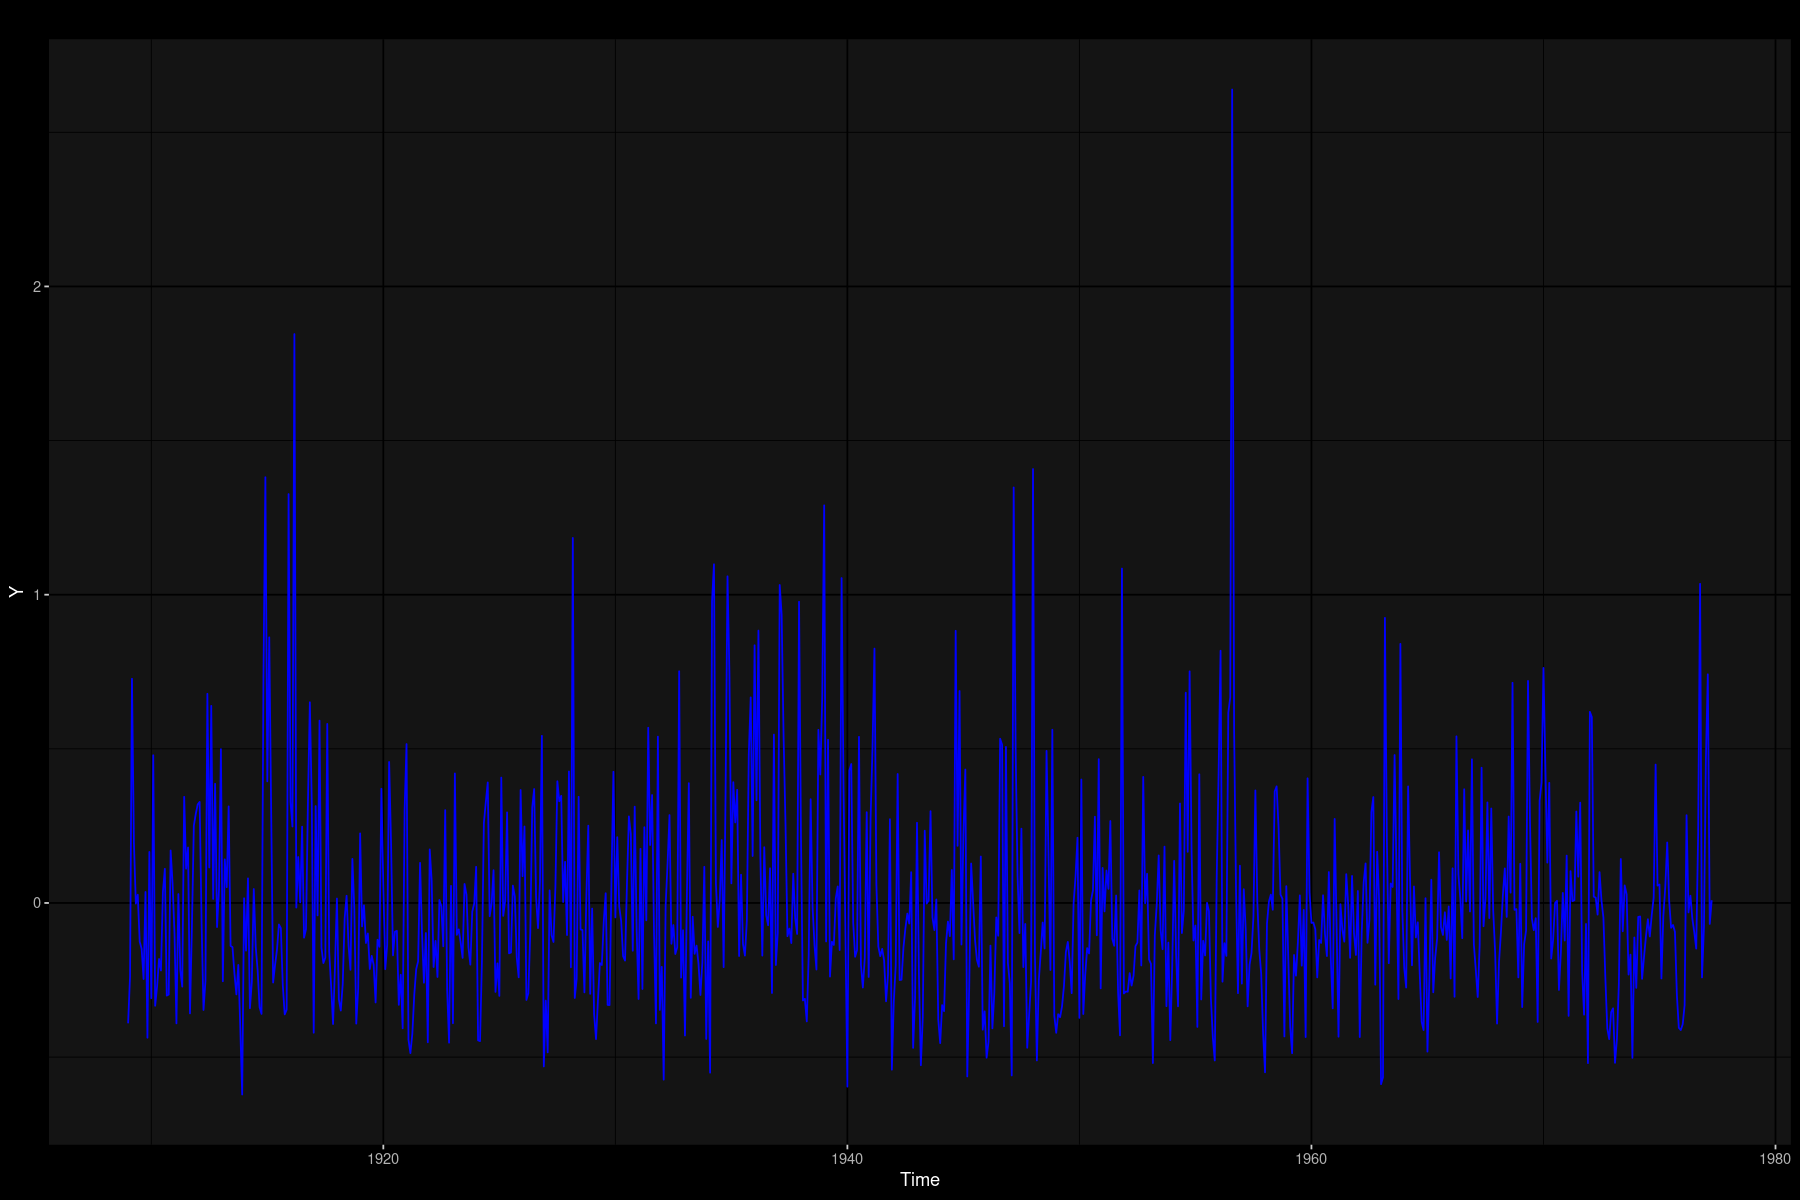

In [12]:
train %>% autoplot(color = "blue") + ylab("Y") + theme(text = element_text(size=20)) + dark_theme_gray()

## Lag Plot da série crua

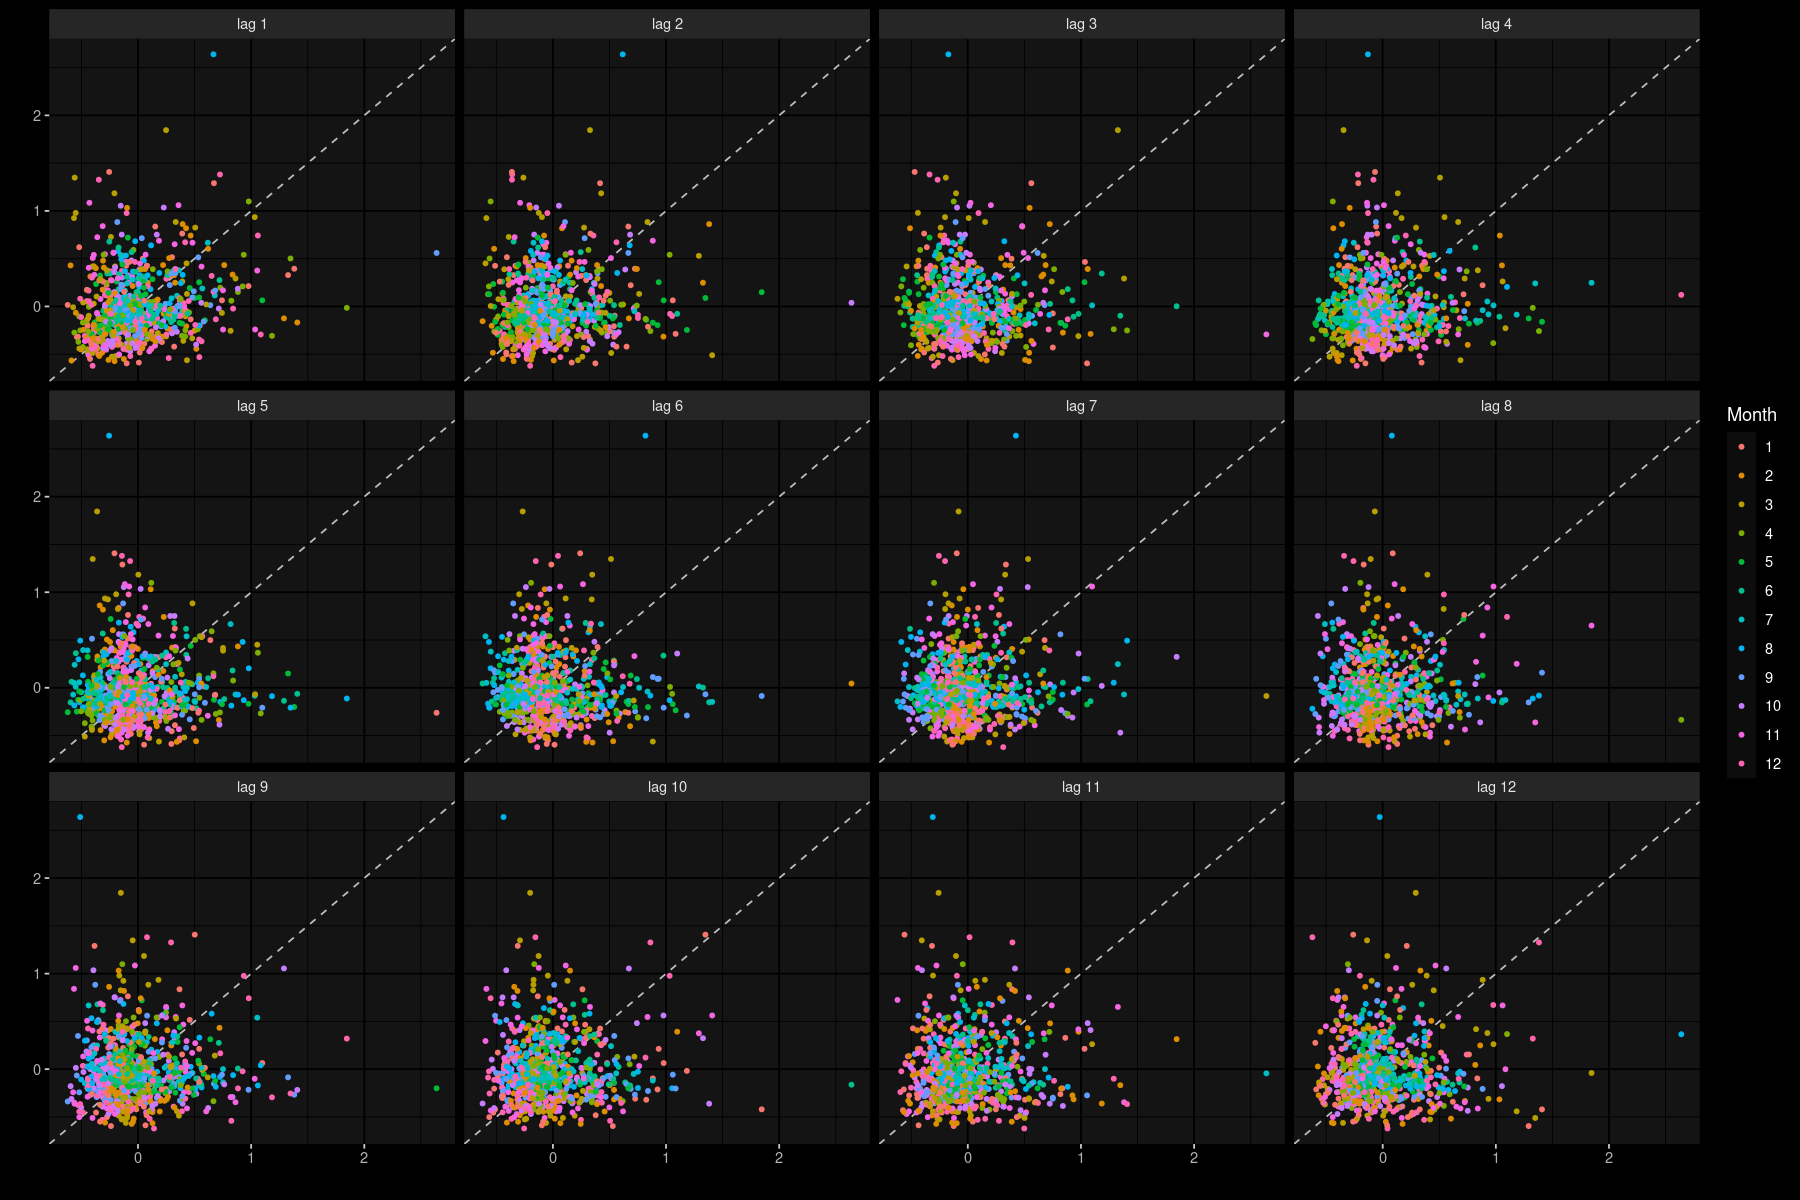

In [13]:
train %>% gglagplot(lag=12, do.lines = F) + theme(text = element_text(size=20)) + dark_theme_gray()

In [14]:
dcmp <- train %>% mstl()
train_seasadj <- dcmp %>% seasadj()

## Lag Plot da série ajustada sazonalmente

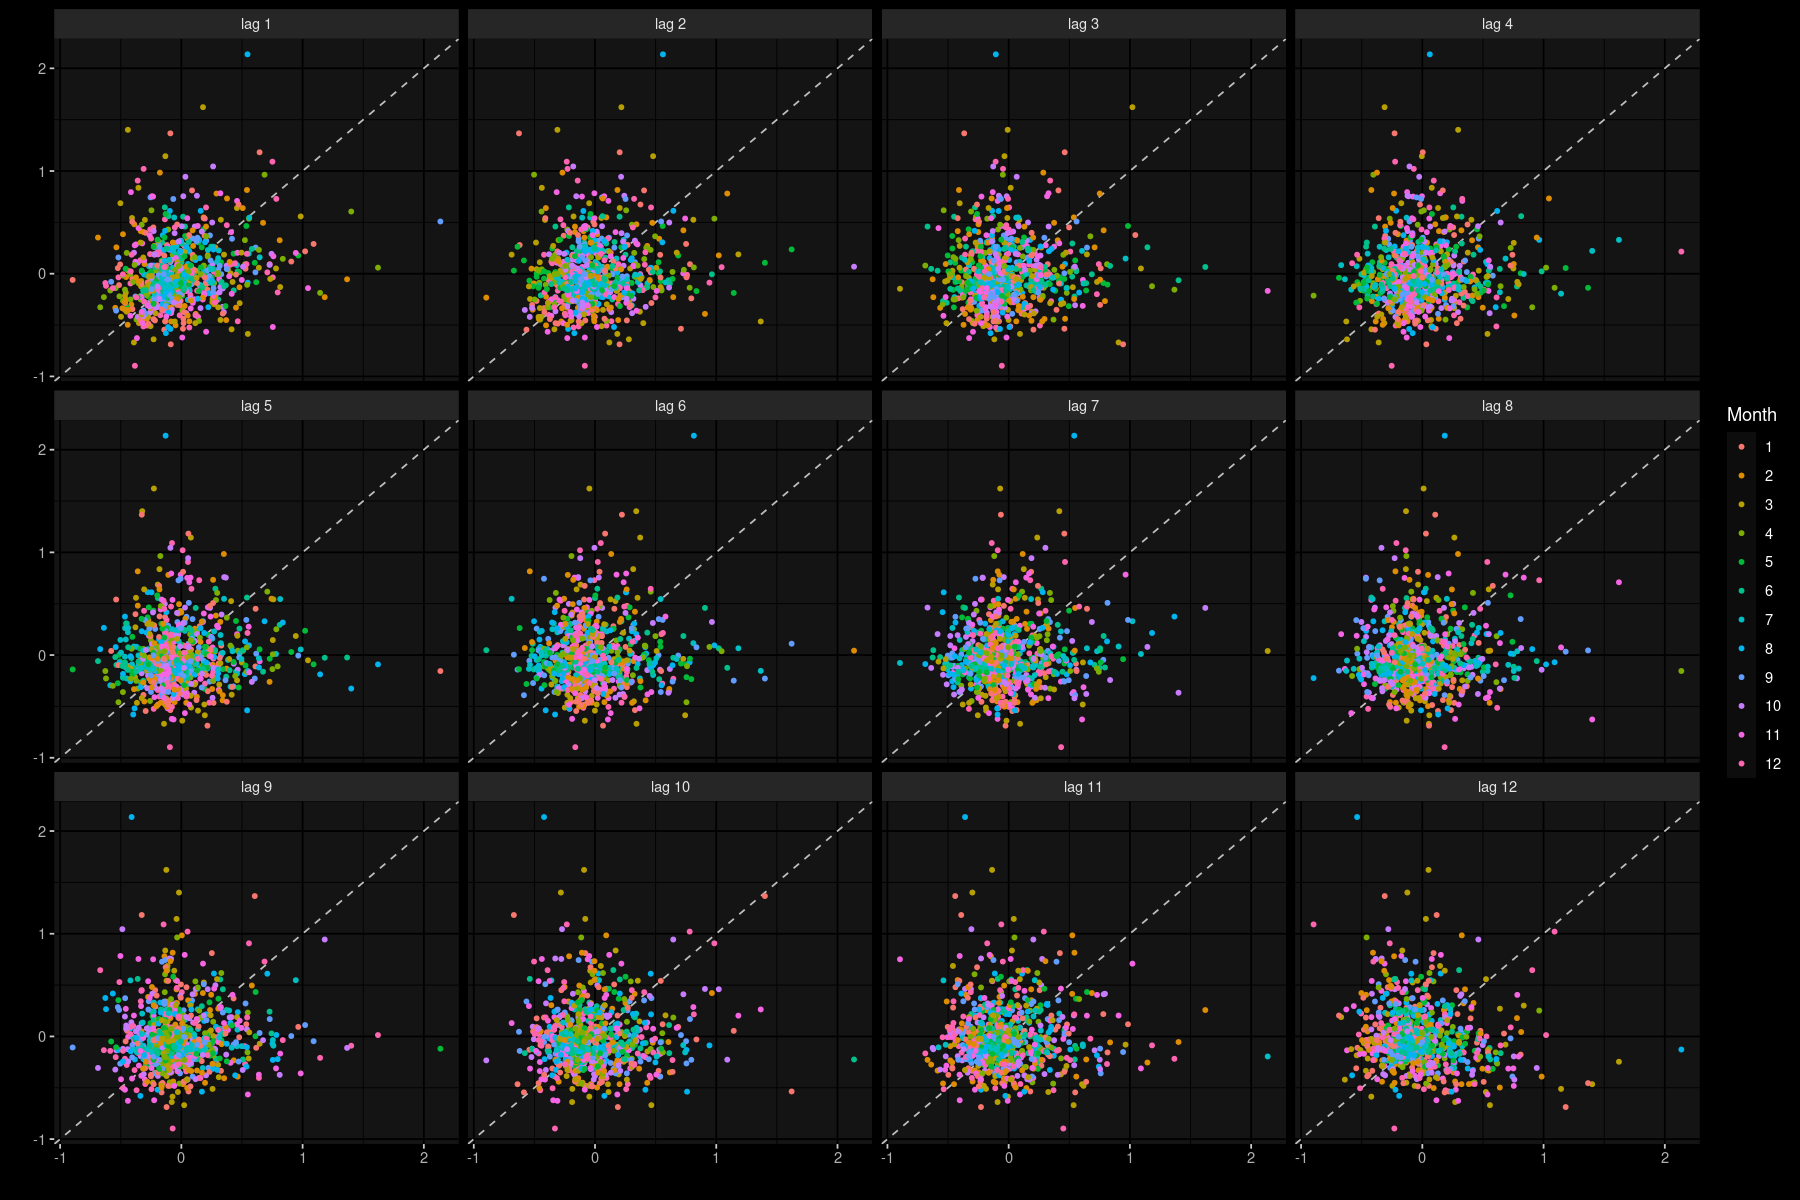

In [15]:
train_seasadj %>% gglagplot(lag=12, do.lines = F) + theme(text = element_text(size=20)) + dark_theme_gray()

## Lag Plot do trend

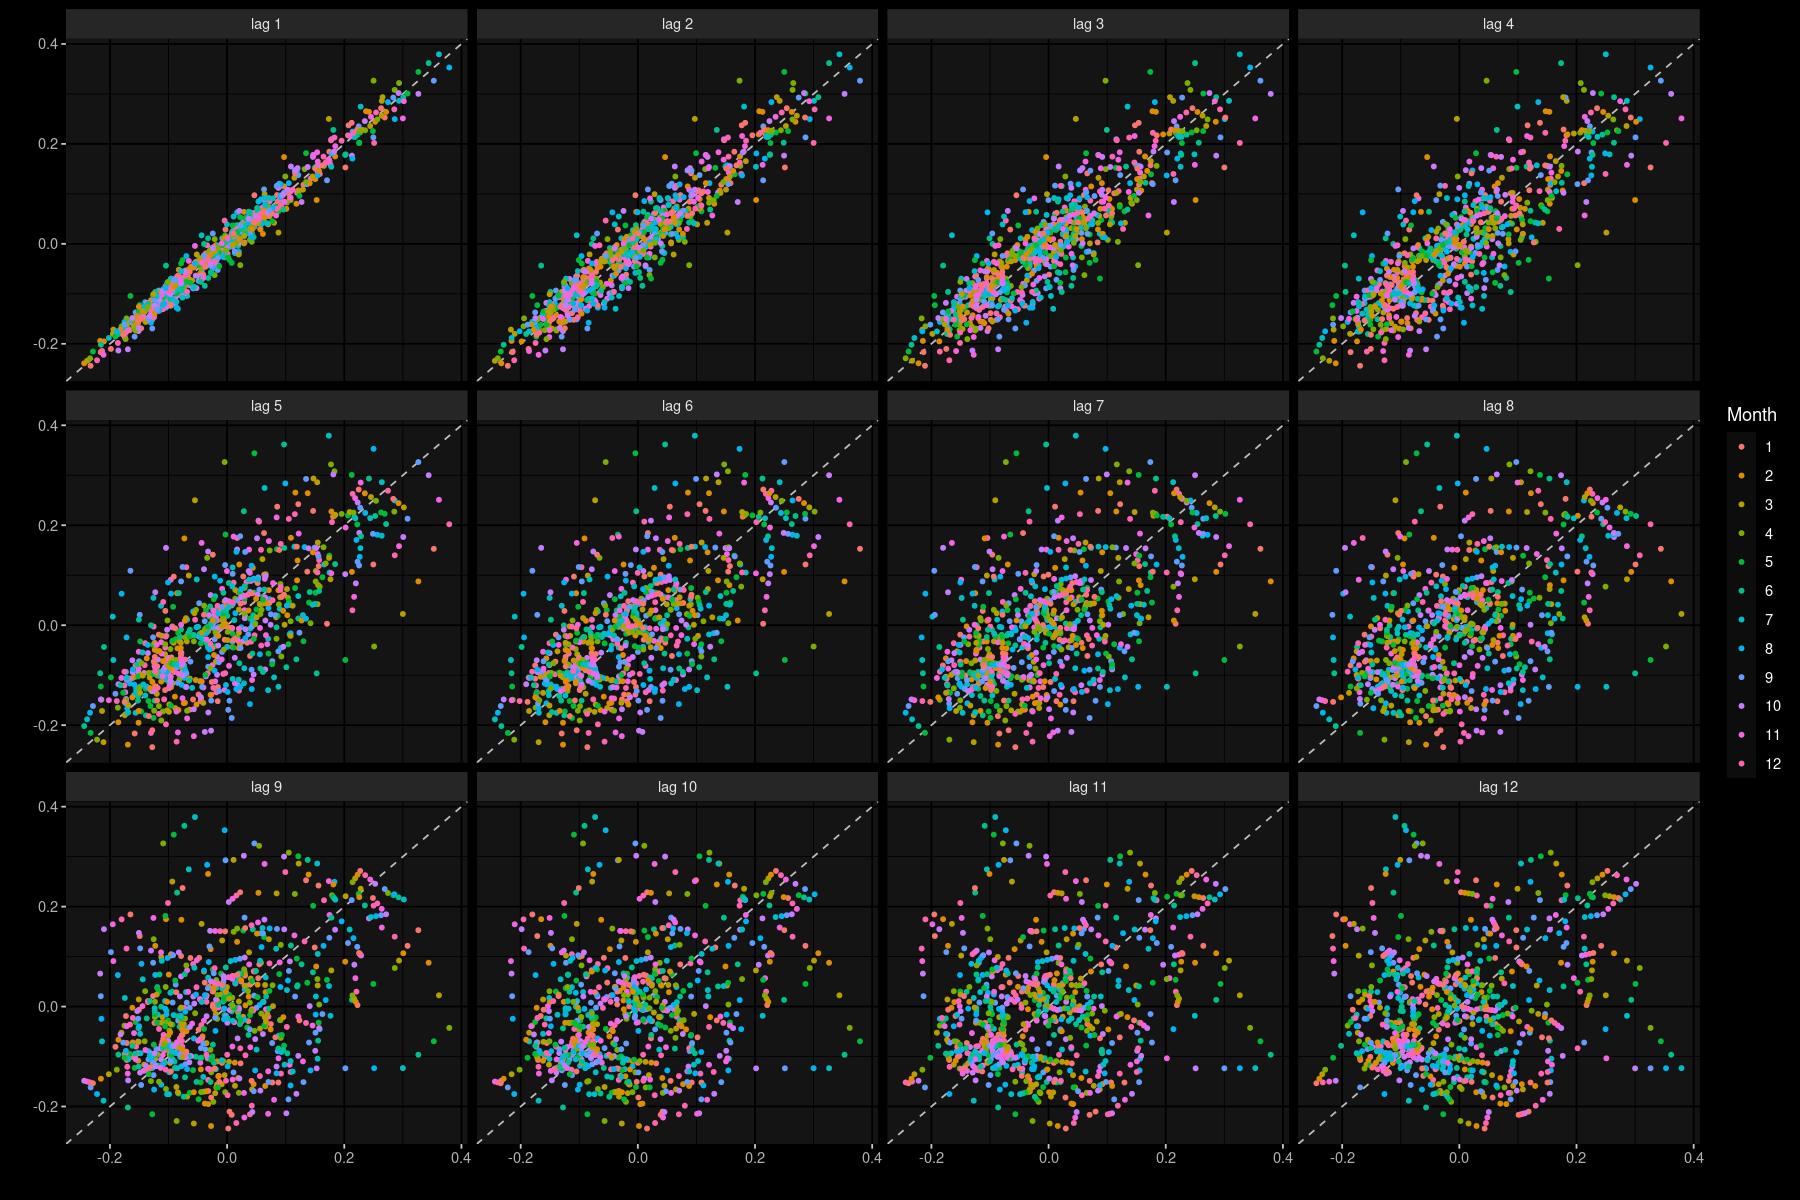

In [16]:
dcmp %>% trendcycle() %>% gglagplot(lag=12, do.lines = F) + theme(text = element_text(size=20)) + dark_theme_gray()

## Coeficientes da SVR clássica em azul e da Híbrida em rosa

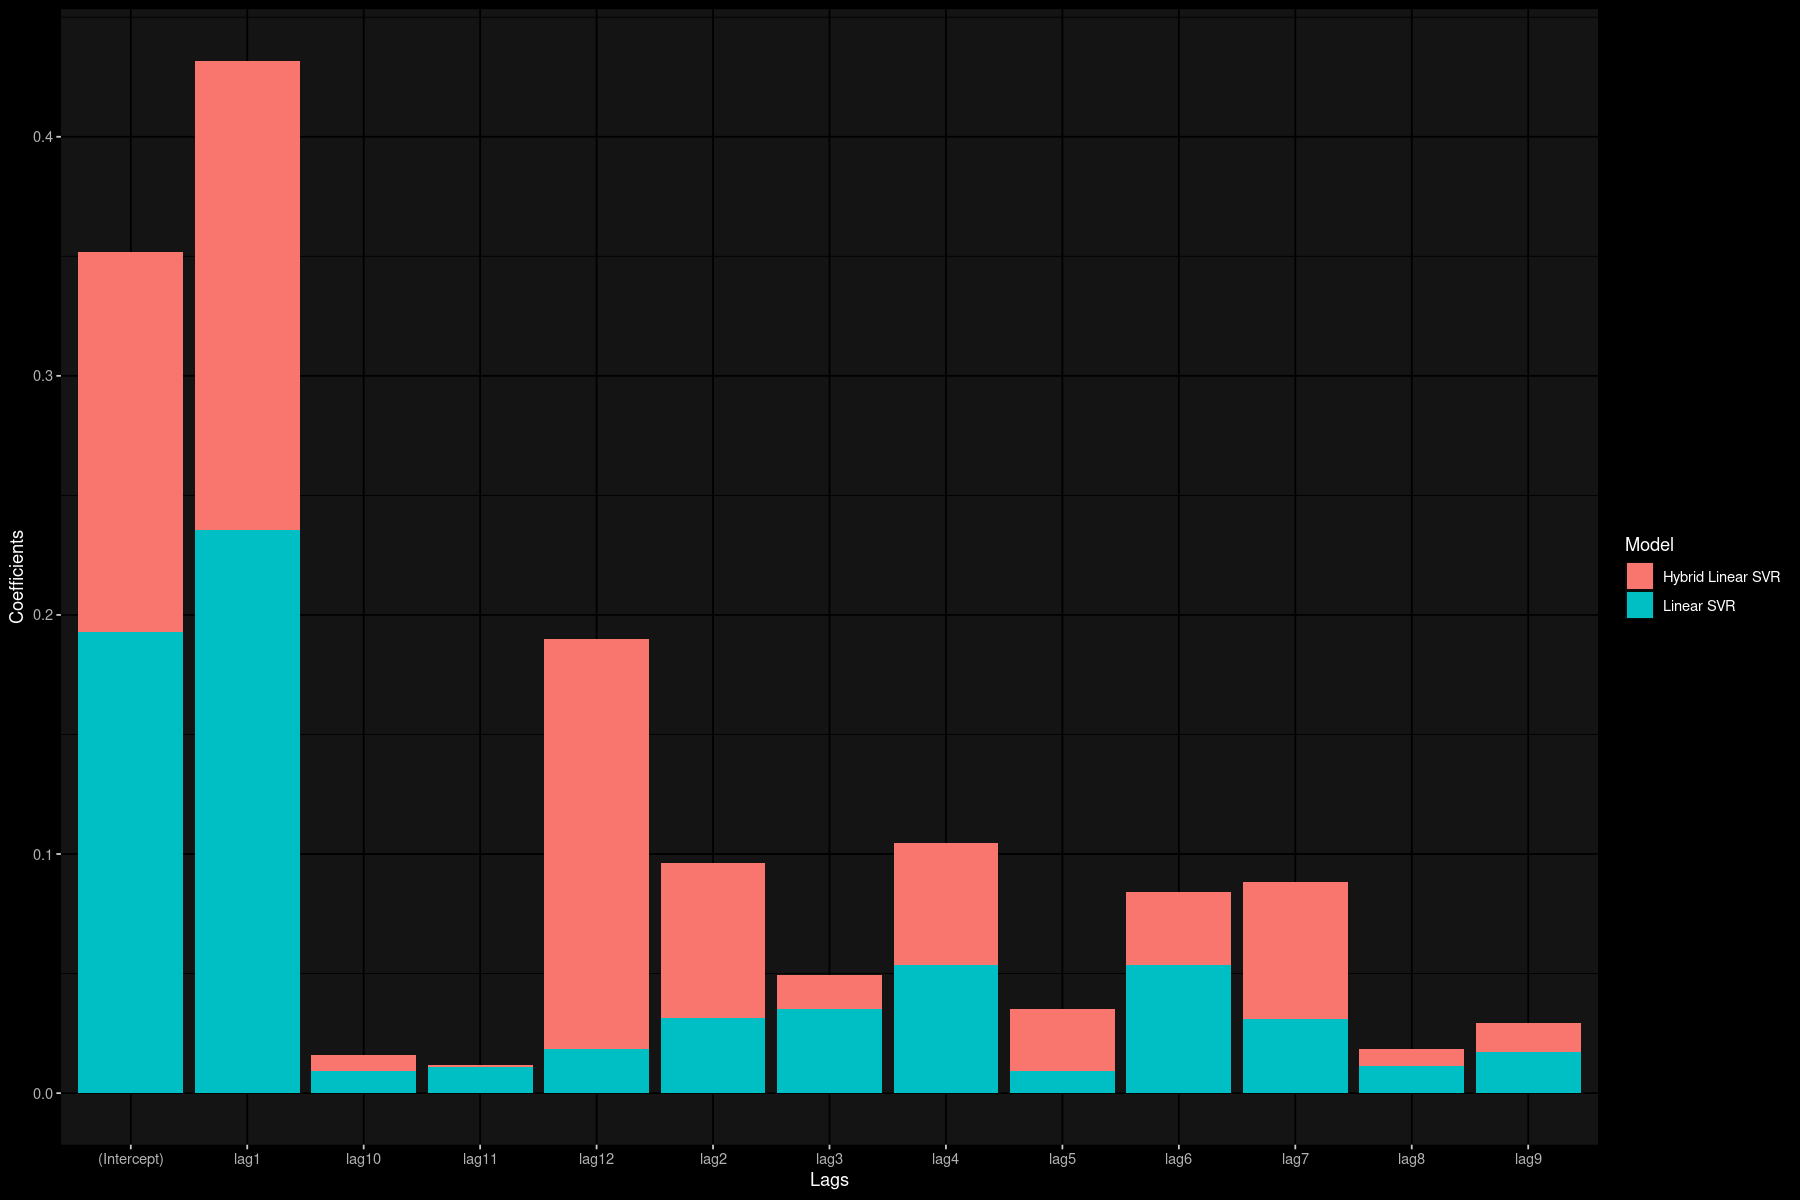

In [17]:
plot_coeffs(train_svm(train), train_svm(train_seasadj)) + dark_theme_gray()